# Laboratorium 1
## Implementacja algorytmów mnożenia macierzy: zwykłego, strassena i odkrytego przez model Alpha Tensor.
### zbiór tensorów reprezentujący mnożenia macierzy znalezione przez AlphaTensor oraz funkcje dokonujące ich zamiany na algorytmy zostały zinspirowane tymi z https://github.com/google-deepmind/alphatensor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple
BlockMatrix = List[List[np.ndarray]]
import datetime as dt
import seaborn as sns

In [2]:
filename = 'factorizations_r.npz'
with open(filename, 'rb') as f:
    factorizations = dict(np.load(f, allow_pickle=True))

In [3]:
def check_key(key):
    dims = [i for i in key.split(",")]
    if dims[0]==dims[1] and dims[0]==dims[2]:
        return int(dims[0])
    return None

In [4]:
square_factorizations = {check_key(key):value for key,value in factorizations.items() if check_key(key)}
square_keys = sorted(list(square_factorizations.keys()),reverse=True)

In [5]:
def hstack(C1, C2):
    if type(C1) == int:
        return C2
    if type(C2) == int:
        return C1
    return np.hstack((C1,C2))

In [6]:
def vstack(C1, C2):
    if type(C1) == int:
        return C2
    if type(C2) == int:
        return C1
    return np.vstack((C1,C2))

In [7]:
def divide(A, B, X, Y, Z):
    #A function, that divides a matrices in halves across every dimension (if possible)
    if X==1 and Y==1 and Z>1:
        A11,A12,A21,A22 = A,None,None,None
        B11,B12,B21,B22 = B[:,:Z//2],B[:,Z//2:],None,None
    elif X==1 and Y>1 and Z==1:
        A11,A12,A21,A22 = A[:,:Y//2],A[:,Y//2:],None,None
        B11,B12,B21,B22 = B[:Y//2,:],None,B[Y//2:,:],None
    elif X>1 and Y==1 and Z==1:
        A11,A12,A21,A22 = A[:X//2,:],None,A[X//2:,:],None
        B11,B12,B21,B22 = B,None,None,None
    elif X==1 and Y>1 and Z>1:
        A11,A12,A21,A22 = A[:,:Y//2],A[:,Y//2:],None,None
        B11,B12,B21,B22 = B[:Y//2,:Z//2],B[:Y//2,Z//2:],B[Y//2:,:Z//2],B[Y//2:,Z//2:]
    elif X>1 and Y==1 and Z>1:
        A11,A12,A21,A22 = A[:X//2,:],None,A[X//2:,:],None
        B11,B12,B21,B22 = B[:,:Z//2],B[:,Z//2:],None,None
    elif X>1 and Y>1 and Z==1:
        A11,A12,A21,A22 = A[:X//2,:Y//2],A[:X//2,Y//2:],A[X//2:,:Y//2],A[X//2:,Y//2:]
        B11,B12,B21,B22 = B[:Y//2,:],None,B[Y//2:,:],None
    elif X>1 and Y>1 and Z>1:
        A11,A12,A21,A22 = A[:X//2,:Y//2],A[:X//2,Y//2:],A[X//2:,:Y//2],A[X//2:,Y//2:]
        B11,B12,B21,B22 = B[:Y//2,:Z//2],B[:Y//2,Z//2:],B[Y//2:,:Z//2],B[Y//2:,Z//2:]
    return ((A11,A12,A21,A22),(B11,B12,B21,B22))

In [8]:
def divide_non_square(A, B, X, Y, Z):
    '''a function, that divides matrices in such a way that both upper left submatrices are 
    always the same size and are both square'''
    p = min(X,Y,Z)
    A11,A12,A21,A22 = A[:p,:p],A[:p,p:],A[p:,:p],A[p:,p:]
    B11,B12,B21,B22 = B[:p,:p],B[:p,p:],B[p:,:p],B[p:,p:]
    if p==X:
        A21, A22 = None, None
    if p==Y:
        A12, A22, B21, B22 = None, None, None, None
    if p==Z:
        B12, B22 = None, None
    return((A11,A12,A21,A22),(B11,B12,B21,B22))

In [9]:
def divide_odd(A, B, X, Y, Z):
    '''a function, that divides matrices in such a way that both upper left submatrices have 
    always both even width and height'''
    x,y,z = X-X%2, Y-Y%2, Z-Z%2
    A11,A12,A21,A22 = A[:x,:y],A[:x,y:],A[x:,:y],A[x:,y:]
    B11,B12,B21,B22 = B[:y,:z],B[:y,z:],B[y:,:z],B[y:,z:]
    if x==0:
        A11, A12 = None, None
    if y==0:
        B11, A11, B12, A21 = None, None, None, None
    if z==0:
        B11, B21 = None, None
    if x==X:
        A21, A22 = None, None
    if y==Y:
        A12, A22, B21, B22 = None, None, None, None
    if z==Z:
        B12, B22 = None, None
    return((A11,A12,A21,A22),(B11,B12,B21,B22))

In [10]:
def get_c_list(div_a, div_b, strassen = False,alphaTensor=False):
    A11,A12,A21,A22 = div_a
    B11,B12,B21,B22 = div_b
    if not strassen and not alphaTensor:
        c1 = multiply(A11,B11)
    elif strassen:
        c1 = strassen_multiply(A11,B11)
    else:
        c1 = alpha_tensor_multiply(A11,B11)
    c2 = multiply(A12,B21)


    c3 = multiply(A11,B12)
    c4 = multiply(A12,B22)


    c5 = multiply(A21,B11)
    c6 = multiply(A22,B21)

    c7 = multiply(A21,B12)
    c8 = multiply(A22,B22)

    return [(c1,c2),(c3,c4),(c5,c6),(c7,c8)]

In [11]:
def get_M_list(div_a, div_b,alphaTensor=False):
    A11,A12,A21,A22 = div_a
    B11,B12,B21,B22 = div_b
    multiplication = alpha_tensor_multiply if alphaTensor else strassen_multiply

    #print(div_a, div_b)
    flops = 0
    mults = 0 
    M = [0 for i in range(7)]
    
    M[0] =multiplication(A11+A22,B11+B22)
    flops += (A11.size+B11.size)#dodawania  
    
    M[1] =multiplication(A21+A22,B11)
    flops += A21.size#dodawania
    
    M[2] =multiplication(A11,B12-B22)
    flops += B12.size#odejmowania  
    
    M[3] =multiplication(A22,B21-B11)
    flops += B21.size#odejmowania
    
    M[4] =multiplication(A11+A12,B22)
    flops += A11.size#dodawania
    
    M[5] =multiplication(A21-A11,B11+B12)
    flops += A11.size+B11.size#odejmowania+dodawania
    
    M[6] =multiplication(A12-A22,B21+B22)
    flops += A12.size+B21.size#odejmowania+dodawania
    
    flops += sum(i[1] for i in M)#sumowanie flopsów z multiplikacji
    mults += sum(i[2] for i in M)#sumowanie mnożeń z multiplikacji
    return M, flops, mults

In [12]:
def strassen_add_M(M):
    C11 =M[0][0]+M[3][0]+M[6][0]-M[4][0]
    C12 =M[2][0]+M[4][0]
    C21 =M[1][0]+M[3][0]
    C22 =M[0][0]+M[2][0]+M[5][0]-M[1][0]
    flops = 0
    for i in (M[0],M[3],M[6],M[4]):
        if type(i[0])!=int:
            flops += i[0].size
        if type(C11)!=int:
            flops -= C11.size
    for i in (M[2],M[4]):
        if type(i[0])!=int:
            flops += i[0].size
        if type(C12)!=int:
            flops -= C11.size
    for i in (M[1],M[3]):
        if type(i[0])!=int:
            flops += i[0].size
        if type(C21)!=int:
            flops -= C11.size
    for i in (M[0],M[2],M[5],M[1]):
        if type(i[0])!=int:
            flops += i[0].size
        if type(C22)!=int:
            flops -= C11.size
    return [C11,C12,C21,C22], flops

In [13]:
def block_split(matrix: np.ndarray, n_rows: int, n_cols: int):
    """Splits `matrix` into a `n_rows x n_cols` block matrix."""
    rows = np.split(matrix, n_rows, axis=0)
    return [np.split(row, n_cols, axis=1) for row in rows]

In [14]:
def _get_n_from_factors(factors: np.ndarray) -> int:
    """Computes the matrix multiplication tensor size n based on `factors`.

    E.g. when multiplying 2x2 matrices with Strassen, the `factors` are of shape
    [4, 7], and this function will return 2.

    Args:
    factors: [3, n^2, R] shaped NumPy array representing a factorization of T_n.
    Returns:
    n, the size of matrices being multiplied by the algorithm represented by
    `factors`.
    """
    u, v, w = factors
    # Assert that the tensor is a cube.
    assert u.shape[0] == v.shape[0]
    assert u.shape[0] == w.shape[0]
    n = int(np.sqrt(u.shape[0]))
    assert u.shape[0] == n ** 2
    return n

In [15]:
def algorithm_from_factors(factors: np.ndarray) -> Callable[[BlockMatrix, BlockMatrix], BlockMatrix]:
    """Returns a function implementing the algorithm described by `factors`.

    Args:
    factors: Matricized factorization of a matrix multiplication tensor, i.e.
      an array of shape [3, n, n, rank].
    Returns:
    Function, which given two block matrices `a` and `b` returns the block
    matrix `c` given by `c = a @ b`.
    """
    assert factors[0].shape[0] == factors[1].shape[0]
    assert factors[1].shape[0] == factors[2].shape[0]
    factors = [factors[0].copy(), factors[1].copy(), factors[2].copy()]
    n = int(np.sqrt(factors[0].shape[0]))
    rank = factors[0].shape[-1]
    factors[0] = factors[0].reshape(n, n, rank)
    factors[1] = factors[1].reshape(n, n, rank)
    factors[2] = factors[2].reshape(n, n, rank)
    # The factors are for the transposed (symmetrized) matrix multiplication
    # tensor. So to use the factors, we need to transpose back.
    factors[2] = factors[2].transpose(1, 0, 2)

    def f(a: BlockMatrix, b: BlockMatrix) -> BlockMatrix:
        """Multiplies block matrices `a` and `b`."""
        n = len(a)
        flops = 0
        mults = 0
        result = [[None] * n for _ in range(n)]
        for alpha in range(rank):
            left = None
            for i in range(n):
                for j in range(n):
                    if factors[0][i, j, alpha] != 0:
                        
                        curr = factors[0][i, j, alpha] * a[i][j]#jeżeli factor ==1 lub -1, nie muszę wykonywać mnożenia
                        ops = a[i][j].size if abs(factors[0][i, j, alpha])!=1 else 0
                        flops += ops
                        mults += ops
                        if left is None:
                            left = curr
                        else:
                            flops += left.size
                            left += curr
            right = None
            for j in range(n):
                for k in range(n):
                    if factors[1][j, k, alpha] != 0:
                        curr = factors[1][j, k, alpha] * b[j][k]
                        ops = b[j][k].size if abs(factors[1][j, k, alpha])!=1 else 0
                        flops += ops
                        mults += ops
                        if right is None:
                            right = curr
                        else:
                            flops += right.size
                            right += curr
            #print(left.shape)
            #print("========")
            #print(right.shape)
            matrix_product,flops_n, mults_n = alpha_tensor_multiply(left,right) # left oraz right są wektorami o rozmiarach 1x1 zatem to jest zwykłe mnożenie

            for i in range(n):
                for k in range(n):
                    if factors[2][i, k, alpha] != 0:
                        curr = factors[2][i, k, alpha] * matrix_product
                        ops = matrix_product.size if abs(factors[2][i, k, alpha])!=1 else 0
                        flops += ops
                        mults += ops
                        if result[i][k] is None:
                            result[i][k] = curr
                        else:
                            flops += curr.size
                            result[i][k] += curr 
        return result,flops+flops_n,mults+mults_n

    return f

In [16]:
def get_factorization(A: np.ndarray, B: np.ndarray) -> Callable[[], None]:
    if A.shape[1] != B.shape[0]:
        raise ValueError
    shape_matrix = [A.shape[0],A.shape[1], B.shape[1]]
    key = ",".join(str(x) for x in shape_matrix)
    u, v, w = factorizations[key]
    n = _get_n_from_factors([u, v, w])
    a = block_split(A, n, n)
    b = block_split(B, n, n)
    algorithm = algorithm_from_factors([u, v, w])
    return (np.array(algorithm(a,b))).reshape(shape_matrix[0],shape_matrix[2])

In [17]:
def multiply(A,B):
    if A is None or B is None:
        return (0,0,0)
    if A.shape[1] != B.shape[0]:
        raise ValueError
    X,Y,Z = A.shape[0],A.shape[1],B.shape[1]
    if X==0 or Y==0 or Z==0:
        raise ArithmeticError
    if X==1 and Y==1 and Z==1:
        return A*B, 1, 1
    else:
        flops = 0
        mults = 0
        div_a, div_b = divide(A, B, X, Y, Z)
        #dzielę macierze na ćwiartki   
        c_list = get_c_list(div_a,div_b)
        C_list = [0 for i in range(4)]
        for i in range(4):
            a,b = c_list[i]
            if type(a[0]) is not int and type(b[0]) is not int:
                flops += a[0].size
                C_list[i] = a[0]+b[0]
            elif type(a[0]) is not int:
                C_list[i] = a[0]
            elif type(b[0]) is not int:
                C_list[i] = b[0]
            else:
                C_list[i] = 0

        flops +=sum([k[1]+l[1] for k,l in c_list])
        mults +=sum([k[2]+l[2] for k,l in c_list])

        U = hstack(C_list[0],C_list[1])
        L = hstack(C_list[2],C_list[3])
        return vstack(U,L), flops, mults

In [18]:
def strassen_multiply(A,B,alphaTensor=False):
    if A is None or B is None:
        return 0,0,0
    if A.shape[1] != B.shape[0]:
        raise ValueError
    X,Y,Z = A.shape[0],A.shape[1],B.shape[1]
    if X==0 or Y==0 or Z==0:
        raise ArithmeticError
    if X==1 and Y==1 and Z==1:
        return A*B, 1, 1
    else:
        flops = 0
        mults = 0
        if X%2==1 or Y%2==1 or Z%2==1:
            div_a, div_b = divide_odd(A, B, X, Y, Z)
            c_list = get_c_list(div_a,div_b,not alphaTensor,alphaTensor)
            C_list = [0 for i in range(4)]
            for i in range(4):
                a,b = c_list[i]
                if type(a[0]) is not int and type(b[0]) is not int:
                    flops += a[0].size
                    C_list[i] = a[0]+b[0]
                elif type(a[0]) is not int:
                    C_list[i] = a[0]
                elif type(b[0]) is not int:
                    C_list[i] = b[0]
                else:
                    C_list[i] = 0

            flops +=sum([k[1]+l[1] for k,l in c_list])
            mults +=sum([k[2]+l[2] for k,l in c_list])

            U = hstack(C_list[0],C_list[1])
            L = hstack(C_list[2],C_list[3])
            return vstack(U,L), flops, mults
        else:
            div_a, div_b = divide(A, B, X, Y, Z)
            #dzielę macierze na ćwiartki   
            M, flops, mults = get_M_list(div_a,div_b,alphaTensor)#7 mnożeń macierzy
            C_list, n_flops = strassen_add_M(M)#n_flops: dodawania/odejmowania tych macierzy  
            U = hstack(C_list[0],C_list[1])
            L = hstack(C_list[2],C_list[3])
            return vstack(U,L), flops + n_flops, mults

In [19]:
def alpha_tensor_multiply(A,B):
    if A is None or B is None:
        return 0,0,0
    if A.shape[1] != B.shape[0]:
        raise ValueError
    X,Y,Z = A.shape[0],A.shape[1],B.shape[1]
    #print(X," ",Y," ",Z)
    if X==0 or Y==0 or Z==0:
        raise ArithmeticError
    if X==1 and Y==1 and Z==1:
        return A*B, 1, 1
    else:
        flops = 0
        mults = 0
        if X!=Y or X!=Z:
            print
            div_a, div_b = divide_non_square(A, B, X, Y, Z)
            c_list = get_c_list(div_a,div_b,strassen = False, alphaTensor = True)
            C_list = [0 for i in range(4)]
            for i in range(4):
                a,b = c_list[i]
                if type(a[0]) is not int and type(b[0]) is not int:
                    flops += a[0].size
                    C_list[i] = a[0]+b[0]
                elif type(a[0]) is not int:
                    C_list[i] = a[0]
                elif type(b[0]) is not int:
                    C_list[i] = b[0]
                else:
                    C_list[i] = 0

            flops +=sum([k[1]+l[1] for k,l in c_list])
            mults +=sum([k[2]+l[2] for k,l in c_list])

            U = hstack(C_list[0],C_list[1])
            L = hstack(C_list[2],C_list[3])
            return vstack(U,L), flops, mults
        else:
            key = ",".join(str(X) for i in range(3))
            if key in square_factorizations:
                u, v, w = factorizations[key]
                n = _get_n_from_factors([u, v, w])
                a = block_split(A, n, n)
                b = block_split(B, n, n)
                algorithm = algorithm_from_factors([u, v, w])
                result = algorithm(a,b)
                return np.array(result[0]).reshape(X,X),result[1], result[2]
            else:
                #szukam algorytmu mnożenia macierzy o bokach będących dzielnikami X
                for k in square_keys:
                    if X%k==0:
                        a = block_split(A, k, k)
                        b = block_split(B, k, k)
                        u, v, w = square_factorizations[k]
                        algorithm = algorithm_from_factors([u, v, w])
                        result = algorithm(a,b)
                        return np.array(result[0]).reshape(X,X),result[1], result[2]
                #jeżeli nie znalazłem algorytmu, to stosuję metodę strassena:
                return strassen_multiply(A,B,alphaTensor=True)

In [20]:
A= np.random.random((5,8))
#A

In [21]:
B= np.random.random((8,13))
#B

In [22]:
A@B

array([[2.40861857, 2.92477981, 3.08780212, 3.169834  , 2.36574037,
        1.61786086, 3.12968714, 1.6263666 , 1.81413419, 2.59676675,
        2.92084019, 3.00444927, 2.66060082],
       [1.87020151, 2.24145833, 2.22109298, 2.29519564, 1.46463044,
        0.95678493, 2.29069777, 1.27625049, 1.1212442 , 1.76402806,
        1.93570121, 2.38800261, 1.8489836 ],
       [2.23574606, 2.37520977, 2.6166234 , 2.85957875, 1.90019617,
        1.46189228, 3.07079944, 1.53480393, 1.64787881, 2.29682959,
        3.02500089, 2.51247079, 2.57259723],
       [2.4927897 , 2.4769405 , 2.76509623, 3.1775187 , 1.89876673,
        1.39622999, 3.39334195, 1.79083819, 1.98558606, 2.39329074,
        3.23430645, 2.97275622, 2.83861036],
       [1.47452468, 1.6297093 , 1.8164654 , 2.1328988 , 1.55796652,
        1.06871162, 1.48581847, 0.54981523, 1.13395727, 1.37888459,
        1.44245846, 1.44629483, 1.18944914]])

In [23]:
multiply(A,B)

(array([[2.40861857, 2.92477981, 3.08780212, 3.169834  , 2.36574037,
         1.61786086, 3.12968714, 1.6263666 , 1.81413419, 2.59676675,
         2.92084019, 3.00444927, 2.66060082],
        [1.87020151, 2.24145833, 2.22109298, 2.29519564, 1.46463044,
         0.95678493, 2.29069777, 1.27625049, 1.1212442 , 1.76402806,
         1.93570121, 2.38800261, 1.8489836 ],
        [2.23574606, 2.37520977, 2.6166234 , 2.85957875, 1.90019617,
         1.46189228, 3.07079944, 1.53480393, 1.64787881, 2.29682959,
         3.02500089, 2.51247079, 2.57259723],
        [2.4927897 , 2.4769405 , 2.76509623, 3.1775187 , 1.89876673,
         1.39622999, 3.39334195, 1.79083819, 1.98558606, 2.39329074,
         3.23430645, 2.97275622, 2.83861036],
        [1.47452468, 1.6297093 , 1.8164654 , 2.1328988 , 1.55796652,
         1.06871162, 1.48581847, 0.54981523, 1.13395727, 1.37888459,
         1.44245846, 1.44629483, 1.18944914]]),
 975,
 520)

In [24]:
strassen_multiply(A,B)

(array([[2.40861857, 2.92477981, 3.08780212, 3.169834  , 2.36574037,
         1.61786086, 3.12968714, 1.6263666 , 1.81413419, 2.59676675,
         2.92084019, 3.00444927, 2.66060082],
        [1.87020151, 2.24145833, 2.22109298, 2.29519564, 1.46463044,
         0.95678493, 2.29069777, 1.27625049, 1.1212442 , 1.76402806,
         1.93570121, 2.38800261, 1.8489836 ],
        [2.23574606, 2.37520977, 2.6166234 , 2.85957875, 1.90019617,
         1.46189228, 3.07079944, 1.53480393, 1.64787881, 2.29682959,
         3.02500089, 2.51247079, 2.57259723],
        [2.4927897 , 2.4769405 , 2.76509623, 3.1775187 , 1.89876673,
         1.39622999, 3.39334195, 1.79083819, 1.98558606, 2.39329074,
         3.23430645, 2.97275622, 2.83861036],
        [1.47452468, 1.6297093 , 1.8164654 , 2.1328988 , 1.55796652,
         1.06871162, 1.48581847, 0.54981523, 1.13395727, 1.37888459,
         1.44245846, 1.44629483, 1.18944914]]),
 1136,
 430)

In [25]:
alpha_tensor_multiply(A,B)

(array([[2.40861857, 2.92477981, 3.08780212, 3.169834  , 2.36574037,
         1.61786086, 3.12968714, 1.6263666 , 1.81413419, 2.59676675,
         2.92084019, 3.00444927, 2.66060082],
        [1.87020151, 2.24145833, 2.22109298, 2.29519564, 1.46463044,
         0.95678493, 2.29069777, 1.27625049, 1.1212442 , 1.76402806,
         1.93570121, 2.38800261, 1.8489836 ],
        [2.23574606, 2.37520977, 2.6166234 , 2.85957875, 1.90019617,
         1.46189228, 3.07079944, 1.53480393, 1.64787881, 2.29682959,
         3.02500089, 2.51247079, 2.57259723],
        [2.4927897 , 2.4769405 , 2.76509623, 3.1775187 , 1.89876673,
         1.39622999, 3.39334195, 1.79083819, 1.98558606, 2.39329074,
         3.23430645, 2.97275622, 2.83861036],
        [1.47452468, 1.6297093 , 1.8164654 , 2.1328988 , 1.55796652,
         1.06871162, 1.48581847, 0.54981523, 1.13395727, 1.37888459,
         1.44245846, 1.44629483, 1.18944914]]),
 1399,
 401)

In [26]:
square_test_sizes = [(2,2),(4,4),(8,8),(16,16),(32,32),(64,64),(128,128),(256,256),(512,512),(1024,1024)]
non_square_test_sizes = [(2,2,3),(4,5,6),(9,13,8),(2,18,3),(19,2,11),(67,8,4),(2,47,67),(1,4,200)]
methods = multiply, strassen_multiply, alpha_tensor_multiply

In [27]:
def test(method, matrixA, matrixB):
    start = dt.datetime.now()
    result, flops, mults = method(matrixA, matrixB)
    end = dt.datetime.now()
    diff = np.sum(result - matrixA@matrixB)**2
    time = (end-start).total_seconds()
    if diff > 10**(-4):
        #sprawdzam, czy błąd kwadratowy nie jest za duży, mały może być - stosujemy w końcu różne algorytmy numeryczne
        print(diff)
        raise ArithmeticError
    return flops, mults, time

In [28]:
def perform_tests(sizes_list):
    results = [[] for i in range(3)]
    for size in sizes_list:
        A = np.random.random(size[:2])
        B = np.random.random(size[-2:])
        for i, method in enumerate(methods):
            results[i].append(test(method, A, B))
    return results

In [29]:
def polynomial(p, x):
    y = np.zeros(x.shape)
    for i, a in enumerate(p[::-1]):
        y += a*(x**i)
    return y
def plot_results(results,test):
    method_names = ["normal multiplication","strassen multiplication", "alpha tensor multiplication"]
    values = ["FLOAT OPERATIONS","FLOAT MULTIPLICATIONS","TIME[s]"]
    if test == "square":
        for value in range(3):
            X = np.linspace(square_test_sizes[0][0],square_test_sizes[-1][0],1000)
            for m in range(3):
                x = [i[0] for i in square_test_sizes]
                y = [i[value] for i in results[m]]
                p =approx = np.polyfit(x,y,3)
                Y = polynomial(p, X)
                plt.plot(X,Y)
                plt.scatter(x,y,marker =(5,m))
                plt.legend(np.array([[m+" estimation",m] for m in method_names]).reshape(-1))
                plt.xlabel("matrix side size")
                plt.ylabel(values[value])
                plt.title(values[value]+" depending on matrices sizes")
                #plt.legend(np.array([[m,m] for m in method_names]).reshape(-1))
            plt.show()
    else:
        for value in range(3):
            fig = plt.figure(figsize=(8, 6), dpi=80)
            for m in range(3):
                x = [str(i[:2])+"x"+str(i[1:]) for i in non_square_test_sizes]
                y = [i[value] for i in results[m]]
                plt.scatter(x,y,marker =(5,m))
                plt.xlabel("matrices shapes")
                plt.ylabel(values[value])
                plt.legend(method_names)
                plt.title(values[value]+" depending on matrices shapes")
            fig.autofmt_xdate()
            plt.show()

In [30]:
square_results = perform_tests(square_test_sizes)
non_square_results = perform_tests(non_square_test_sizes)

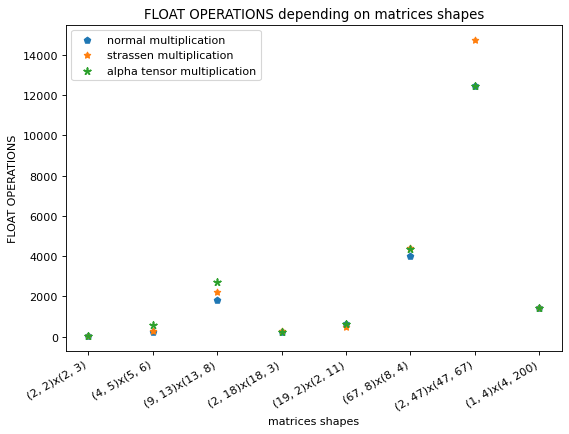

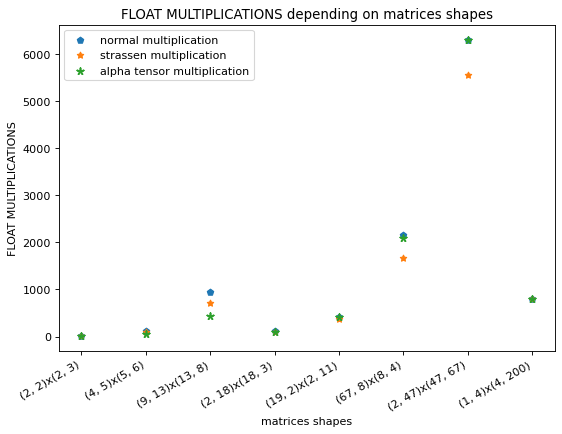

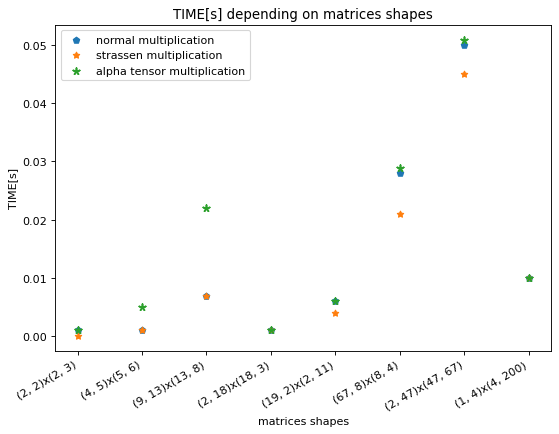

In [31]:
plot_results(non_square_results,"non square")
# nie dokonuję interpolacji, bo kształty nie są rosnące

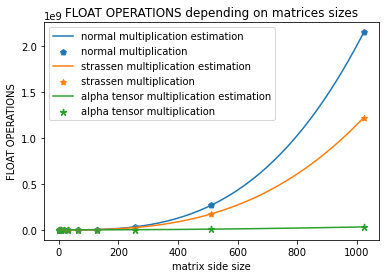

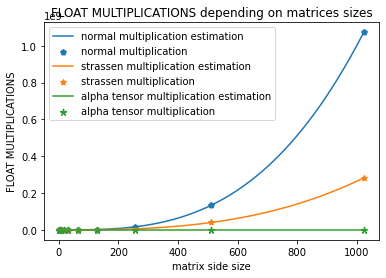

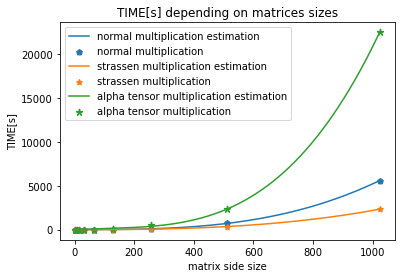

In [32]:
plot_results(square_results,"square")